<a href="https://colab.research.google.com/github/sudhanshurai360/City-of-Chicago-Crimes-using-Pyspark/blob/main/joins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with joins

## Download and install Spark

In [2]:
!ls 

sample_data


In [3]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [89.9 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [903 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu

## Setup environment

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

## Downloading and preprocessing Chicago's Reported Crime Data

In [ ]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
!ls -l

--2022-08-12 02:13:20--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

?accessType=DOWNLOA     [  <=>               ]   1.22G  3.22MB/s               

In [ ]:
!mv rows.csv\?accessType\=DOWNLOAD reported-crimes.csv
!ls -l

In [ ]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))
rc.show(5)

## Joins

**Download police station data**

Here we will download the police station data from the same chicago data portal. We will merge the above data with police station data to find some more information such as the district name.

In [11]:
!wget -O police-station.csv https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD


--2022-08-12 02:26:59--  https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘police-station.csv’

police-station.csv      [ <=>                ]   5.57K  --.-KB/s    in 0s      

2022-08-12 02:26:59 (387 MB/s) - ‘police-station.csv’ saved [5699]



In [12]:
ls

police-station.csv   sample_data/                spark-2.3.1-bin-hadoop2.7.tgz
reported-crimes.csv  spark-2.3.1-bin-hadoop2.7/  spark-warehouse/


In [14]:
ps=spark.read.csv('police-station.csv',header=True)
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 1172080.029| 1908086.527|41.90324165|-87.64335214|(41.9032416531, -

**The reported crimes dataset has only the district number. Add the district name by joining with the police station dataset**

Now we will cache the rc dataset and then run an action to execute the cache command since cache command is lazily evaluated.
This is done to speed up the processing since rc data will be in cache.

In [15]:
rc.cache()
rc.count()

6755492

In [16]:
ps.select(col('District')).distinct().show(20)

+------------+
|    District|
+------------+
|           7|
|          15|
|          11|
|           3|
|           8|
|          22|
|          16|
|           5|
|          18|
|          17|
|           6|
|          19|
|          25|
|Headquarters|
|          24|
|           9|
|           1|
|          20|
|          10|
|           4|
+------------+
only showing top 20 rows



In [18]:
rc.select(col('District')).distinct().show(20)

+--------+
|District|
+--------+
|     009|
|     012|
|     024|
|    null|
|     031|
|     015|
|     006|
|     019|
|     020|
|     011|
|     025|
|     005|
|     003|
|     016|
|     018|
|     008|
|     022|
|     001|
|     014|
|     010|
+--------+
only showing top 20 rows



We see that there are added 0 in front of district code in rc. so we need to do padding in ps dataframe.
we need to explore the spark functions to find if any such function exists.

In [19]:
from pyspark.sql.functions import lpad

In [20]:
help(lpad)

Help on function lpad in module pyspark.sql.functions:

lpad(col, len, pad)
    Left-pad the string column to width `len` with `pad`.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(lpad(df.s, 6, '#').alias('s')).collect()
    [Row(s='##abcd')]
    
    .. versionadded:: 1.5



In [24]:
ps.select(lpad(col('District'),3,'0')).show(10)

+--------------------+
|lpad(District, 3, 0)|
+--------------------+
|                 Hea|
|                 018|
|                 019|
|                 020|
|                 022|
|                 024|
|                 025|
|                 001|
|                 002|
|                 003|
+--------------------+
only showing top 10 rows



In [29]:
ps=ps.withColumn('Format_District',lpad(col('District'),3,'0'))

In [30]:
ps.show(10)

+------------+--------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+---------------+
|    DISTRICT| DISTRICT NAME|             ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format District|Format_District|
+------------+--------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+---------------+
|Headquarters|  Headquarters| 3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|            Hea|            Hea|
|          18|    Near North|  1160 N Larrabee St|Chicago|  

In [34]:
rc.join(ps,rc.District==ps.Format_District,'left_outer').show(10)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------+-------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+---------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|DISTRICT|DISTRICT NAME|             ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION

In [36]:
ps.columns

['DISTRICT',
 'DISTRICT NAME',
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'Format District',
 'Format_District']

We can also drop the irrelevant using .drop

In [38]:
rc.join(ps,rc.District==ps.Format_District,'left_outer').drop(
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'Format District',
 'Format_District'
).show(10)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+-------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|Year|          Updated On|DISTRICT|DISTRICT NAME|
+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+-------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            61|     08B|2015|02/10/2018 03:50:...|       9|      Deering|
|10224739|   HY411615|2015-09-04 11:30:00| 008XX

In [46]:
from pyspark.sql.functions import to_date
from pyspark.sql.functions import dayofweek

#### What is the most frequently reported non criminal activity?

https://docs.oracle.com/javase/7/docs/api/java/text/SimpleDateFormat.html

In [45]:
rc.select(dayofweek(col('Date'))).show(1)

+---------------+
|dayofweek(Date)|
+---------------+
|              7|
+---------------+
only showing top 1 row



In [51]:
rc.select(dayofweek(col('Date'))).show(4)

+---------------+
|dayofweek(Date)|
+---------------+
|              7|
|              6|
|              7|
|              7|
+---------------+
only showing top 4 rows



In [56]:
rc.groupby(dayofweek(col('Date'))).count('Date')

TypeError: ignored

In [57]:
rc.show(10)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| fal

In [61]:
rc.select(col('Primary Type')).distinct().show(40,truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|OFFENSE INVOLVING CHILDREN       |
|CRIMINAL SEXUAL ASSAULT          |
|STALKING                         |
|PUBLIC PEACE VIOLATION           |
|OBSCENITY                        |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|ARSON                            |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|CRIMINAL TRESPASS                |
|ASSAULT                          |
|NON - CRIMINAL                   |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|THEFT                            |
|BATTERY                          |
|ROBBERY                          |
|HOMICIDE                         |
|RITUALISM                        |
|PUBLIC INDECENCY                 |
|CRIM SEXUAL ASSAULT              |
|HUMAN TRAFFICKING                |
|INTIMIDATION                     |
|PROSTITUTION                     |
|DECEPTIVE PRACTICE         

So there are 3 values with non criminal thing, we will use filter to separate.

In [63]:
nc=rc.filter( (col('Primary Type')=='NON-CRIMINAL (SUBJECT SPECIFIED)') | (col('Primary Type')=='NON - CRIMINAL') | (col('Primary Type')=='NON-CRIMINAL'))
nc.show()

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10233370|   HY421530|2015-09-13 10:45:00|  010XX S MENARD AVE|5114|      NON - CRIMINAL|   FOID - REVOCATION|           RESIDE

In [65]:
nc.groupBy(col('Description')).count().orderBy('count',ascending=False).show(truncate=False)

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |107  |
|FOID - REVOCATION                          |75   |
|NOTIFICATION OF CIVIL NO CONTACT ORDER     |9    |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|CONCEALED CARRY LICENSE REVOCATION         |4    |
|FOUND PASSPORT                             |4    |
|GUN OFFENDER NOTIFICATION-NO CONTACT       |3    |
+-------------------------------------------+-----+



#### Find the day of the week with the most reported crime

In [66]:
from pyspark.sql.functions import dayofweek

In [67]:
help(dayofweek)

Help on function dayofweek in module pyspark.sql.functions:

dayofweek(col)
    Extract the day of the week of a given date as integer.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(dayofweek('dt').alias('day')).collect()
    [Row(day=4)]
    
    .. versionadded:: 2.3



In [68]:
from pyspark.sql.functions import date_format

In [69]:
help(date_format)

Help on function date_format in module pyspark.sql.functions:

date_format(date, format)
    Converts a date/timestamp/string to a value of string in the format specified by the date
    format given by the second argument.
    
    A pattern could be for instance `dd.MM.yyyy` and could return a string like '18.03.1993'. All
    pattern letters of the Java class `java.text.SimpleDateFormat` can be used.
    
    .. note:: Use when ever possible specialized functions like `year`. These benefit from a
        specialized implementation.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_format('dt', 'MM/dd/yyy').alias('date')).collect()
    [Row(date='04/08/2015')]
    
    .. versionadded:: 1.5



In [71]:
rc.select(date_format(col('Date'),'E')).show(10)

+--------------------+
|date_format(Date, E)|
+--------------------+
|                 Sat|
|                 Fri|
|                 Sat|
|                 Sat|
|                 Sat|
|                 Sat|
|                 Fri|
|                 Sat|
|                 Sat|
|                 Sun|
+--------------------+
only showing top 10 rows



In [73]:
rc.groupBy(date_format(col('Date'),'E')).count().orderBy('count',ascending=False).show(10)

+--------------------+-------+
|date_format(Date, E)|  count|
+--------------------+-------+
|                 Fri|1017297|
|                 Wed| 974202|
|                 Tue| 968341|
|                 Sat| 965431|
|                 Thu| 964920|
|                 Mon| 953058|
|                 Sun| 912243|
+--------------------+-------+



#### Now we try to plot above using matplotlib and pandas. To access the above result row wise we use .collect()

In [75]:
rc.groupBy(date_format(col('Date'),'E')).count().collect()

[Row(date_format(Date, E)='Sun', count=912243),
 Row(date_format(Date, E)='Mon', count=953058),
 Row(date_format(Date, E)='Thu', count=964920),
 Row(date_format(Date, E)='Sat', count=965431),
 Row(date_format(Date, E)='Wed', count=974202),
 Row(date_format(Date, E)='Fri', count=1017297),
 Row(date_format(Date, E)='Tue', count=968341)]

To access it we can use list comprehension

In [78]:
dow=[x[0] for x in rc.groupBy(date_format(col('Date'),'E')).count().collect()]
dow

['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue']

In [79]:
cnt=[x[1] for x in rc.groupBy(date_format(col('Date'),'E')).count().collect()]
cnt

[912243, 953058, 964920, 965431, 974202, 1017297, 968341]

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

In [81]:
cp=pd.DataFrame({'Day of Week':dow,'Count':cnt})
cp

,Day of Week,Count
0,Sun,912243
1,Mon,953058
2,Thu,964920
3,Sat,965431
4,Wed,974202
5,Fri,1017297
6,Tue,968341


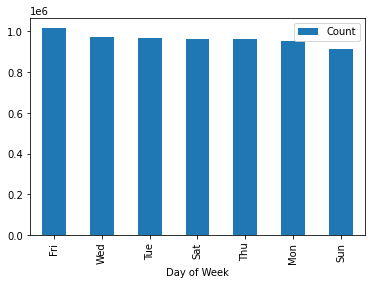

In [83]:
cp.sort_values('Count',ascending=False).plot(kind='bar',x='Day of Week',y='Count')